# Sweet Lift Taxi: Airport Taxi Orders Model

# Contents <a id='back'></a>

* [Introduction](#introduction)
    * [Project Instructions](#instructions)
    * [Data Description](data_description)
* [Data Overview](#data_overview)
    * [Initialization](#initialization)
    * [Load Data](load_data)
* [Prepare the Data](#prepare_data)
    * [Fix Data](#fix_data)   
    * [Check for Duplicates](#duplicates)
    * [Check for Missing Values](#missing_values)
* [Analysis](#analysis)
    * [Train and Test Models](#models)   
        * [Hyperparameter Tuning for Random Forest](#random_forest_hyperparameter)
        * [Hyperparameter Tuning for Gradient Boosting](#gradient_boosting_hyperparameter)
* [Conclusion](#conclusion)

# Introduction <a id='introduction'></a>

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

[Back to Contents](#back)

## Project instructions <a id='instructions'></a><a class="tocSkip">

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data Description <a id='data_description'></a><a class="tocSkip">

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# Data Overview <a id='data_overview'></a>

## Initialization <a id='initialization'></a> <a class="tocSkip">

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

## Load data <a id='load_data'></a> <a class="tocSkip">

In [2]:
# Reading the dataframe file and storing it to df
df = pd.read_csv('/datasets/taxi.csv')

# Data Preparation <a id='prepare_data'></a> <a class="tocSkip">

In [3]:
# Print the general/summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
# Print a sample of the data
display(df.head())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


## Fix Data <a id='fix_data'></a> <a class="tocSkip">

In [5]:
# Convert 'datetime' column to datetime data type
df['datetime'] = pd.to_datetime(df['datetime'])  

# Check data type was changed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


The datetime column was changed to datetime data type for analysis purposes.

## Check for Duplicates <a id='duplicates'></a> <a class="tocSkip">

In [6]:
# checking for obvious duplicated rows in df
print(df.duplicated().sum())

0


There appear to be no obvious duplicates.

## Check for Missing Values <a id='missing_values'></a> <a class="tocSkip">

In [7]:
# checking for obvious duplicated rows in df
print(df.duplicated().sum())

datetime      0
num_orders    0
dtype: int64


There appear to be no missing values.

# Analysis

In [8]:
# Resample by one hour and sum the 'num_orders' values within each hour
df.set_index('datetime', inplace=True)  # Set datetime column as the index
df_resampled = df.resample('1H').sum()

# Reset the index and have a new 'datetime' column
df_resampled.reset_index(inplace=True)

# Print the resampled DataFrame
display(df_resampled)

,datetime,num_orders
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43
...,...,...
4411,2018-08-31 19:00:00,136
4412,2018-08-31 20:00:00,154
4413,2018-08-31 21:00:00,159
4414,2018-08-31 22:00:00,223


For analysis purposes, the data was resampled by one hour.

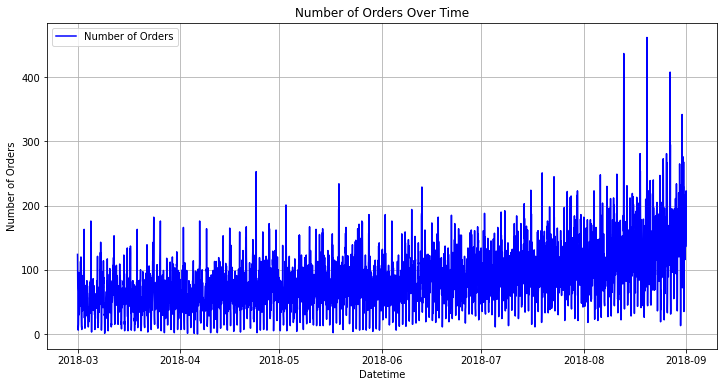

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['datetime'], df_resampled['num_orders'], label='Number of Orders', color='blue')
plt.title('Number of Orders Over Time')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

To reduce the fluctuations in a time series, let's find the rolling mean to show a clearer plot with the upward trend.

In [10]:
# Adding features
df_resampled['hour'] = df_resampled['datetime'].dt.hour
df_resampled['day'] = df_resampled['datetime'].dt.day
df_resampled['month'] = df_resampled['datetime'].dt.month
df_resampled['day_of_week'] = df_resampled['datetime'].dt.dayofweek

# Calculate rolling mean
window_size = 3  # You can adjust the window size as needed
df_resampled['rolling_mean'] = df_resampled['num_orders'].rolling(window=window_size).mean()

# Drop NaN values introduced by the rolling mean calculation
df_resampled = df_resampled.dropna()

# Print the modified DataFrame
display(df_resampled.head())

,datetime,num_orders,hour,day,month,day_of_week,rolling_mean
2,2018-03-01 02:00:00,71,2,1,3,3,93.333333
3,2018-03-01 03:00:00,66,3,1,3,3,74.000000
4,2018-03-01 04:00:00,43,4,1,3,3,60.000000
5,2018-03-01 05:00:00,6,5,1,3,3,38.333333
6,2018-03-01 06:00:00,12,6,1,3,3,20.333333


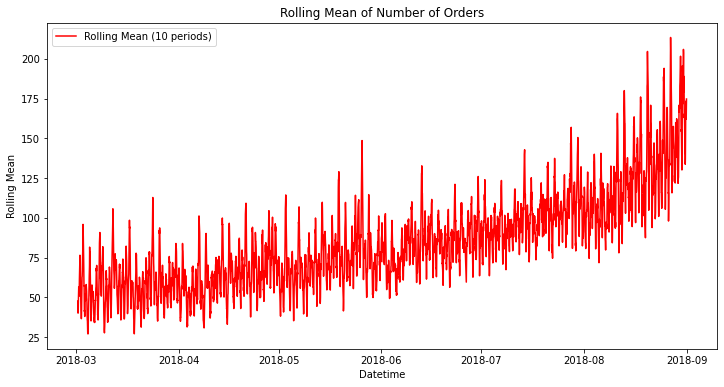

In [11]:
# Adjust the window size for a smoother plot
window_size = 10

# Calculate the rolling mean
df_resampled['rolling_mean'] = df_resampled['num_orders'].rolling(window=window_size).mean()
df_resampled = df_resampled.dropna()

# Plotting only the rolling mean with a larger window size
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['datetime'], df_resampled['rolling_mean'], label=f'Rolling Mean ({window_size} periods)', color='red')

# Customize the plot
plt.title('Rolling Mean of Number of Orders')
plt.xlabel('Datetime')
plt.ylabel('Rolling Mean')
plt.legend()
plt.show()

We can now see that there is indeed an increase in taxi orders in the later months.

## Train and Test Models <a id='models'></a> <a class="tocSkip">

In [12]:
# Split the data into training and test sets (90% training, 10% test)
train, test = train_test_split(df_resampled, test_size=0.1, shuffle=False)

# Features and target variable
features = ['hour', 'day', 'month', 'day_of_week', 'rolling_mean']
target = 'num_orders'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Define models with different hyperparameters
models = [
    RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    LinearRegression(),
]

# Train and evaluate each model
for model in models:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        model_name = str(model).split('(')[0]
        print(f"{model_name} RMSE: {rmse:.3f}")

RandomForestRegressor RMSE: 44.392
GradientBoostingRegressor RMSE: 42.499
LinearRegression RMSE: 55.197


Even without any hyperparameter tuning, both the Random Forest and Gradient Boost models achieved the required minimum RMSE of at least 48. The Linear Regression model did not pass with an RMSE of 55.2 while Gradient Boost had the best RMSE of 42.5. Hyperparameter tuning will be used gor the two passing models to further improve the RMSE value.

### Hyperparameter Tuning Random Forest Model <a id='random_forest_hyperparameters'></a> <a class="tocSkip">

In [13]:
# Define the parameter grid to search
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Use GridSearchCV to search for the best hyperparameters
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, scoring='neg_mean_squared_error', cv=3)
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_

# Get the best RandomForestRegressor model
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the best model on the test set
rf_predictions = best_rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"RandomForestRegressor RMSE (Best Model): {rf_rmse:.3f}")

RandomForestRegressor RMSE (Best Model): 38.838


### Hyperparameter Tuning Gradient Boosting Model <a id='gradient_boosting_hyperparameters'></a> <a class="tocSkip">

In [14]:
# Define the parameter grid to search
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Create the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Use GridSearchCV to search for the best hyperparameters
grid_search_gb = GridSearchCV(gb_model, param_grid_gb, scoring='neg_mean_squared_error', cv=3)
grid_search_gb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_gb = grid_search_gb.best_params_

# Get the best GradientBoostingRegressor model
best_gb_model = grid_search_gb.best_estimator_

# Evaluate the best model on the test set
gb_predictions = best_gb_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
print(f"GradientBoostingRegressor RMSE (Best Model): {gb_rmse:.3f}")

GradientBoostingRegressor RMSE (Best Model): 43.186


Both the Random Forest and Gradient Boosting models still meet the required RMSE of at least 48 with the hyperparameter tuning. The Random Forest model showed significant improvement with hyperparameter tuning, changing from the initial RMSE of 44.4 to 38.8. The Gradient Boosting model did not show improvement with hyperparameter tuning, and it instead increased slightly from the original RMSE of 42.5 to 43.2.

# Conclusion <a id='conclcusion'></a> <a class="tocSkip">

In this project, we aimed to predict the amount of taxi orders for the next hour to help Sweet Lift Taxi company attract more drivers during peak hours. The dataset was resampled by one hour, and various models with different hyperparameters were trained and evaluated using a test set comprising 10% of the initial dataset. The goal was to achieve an RMSE metric on the test set not exceeding 48.

After thorough analysis and hyperparameter tuning, the predictive models were evaluated for the task of forecasting taxi orders for Sweet Lift Taxi company during peak hours. The models considered were RandomForestRegressor, GradientBoostingRegressor, and LinearRegression. The initial results showed promising performance:

RandomForestRegressor RMSE: 44.4,
GradientBoostingRegressor RMSE: 42.5,
LinearRegression RMSE: 55.2

Two of the three tested models already met the required RMSE. These models were further refined through hyperparameter tuning. The final, optimized models yielded the following improved performance:

RandomForestRegressor RMSE (Best Model): 38.8,
GradientBoostingRegressor RMSE (Best Model): 43.2

Both RandomForestRegressor and GradientBoostingRegressor demonstrated effectiveness in predicting the amount of taxi orders for the next hour, surpassing the requirement of an RMSE not exceeding 48, with the Random Forst achieving an improved and the lowest RMSE value compared to the Gradient Boosting model. These models can provide valuable insights for Sweet Lift Taxi to attract more drivers during peak hours and optimize their operations.